In [17]:
#| echo: false
import seaborn as sns
import random

Life is full of solving problems. We are always searching for solutions and in Artificial Intelligence there's a whole subfield about search algorithms. In this article I want to introduce the algorithm which fascinates me the most.

## The problem

Search Problems are hard to solve. But why is that? Essentially, it is because the thing we want to find is a lot less common than the things we do not want to find. Take  for example a rubix cube. It has 43 quintillion configurations, out of only 1 is the correct one. If we were to approach this problem without a strategy, the chances are 1:43 quintillion of finding the solution every time we make a turn. As you may know, Entropy(def), sometimes known as unorder or chaos, tends to a maximum. And it's the reason that when making random turns on the rubix cube leaves it in an unusable state: the amount of unsolved states, that is problematic states, is much higher than the one configuration in whihc it is solved. It almost seems like most of our problems exist because we want order (low entropy) while the world tends to move toward chaos (high entropy). If we could reverse these laws, even if it's just for a moment, we could solve so many problems without an effort. If you had a button to inverse Entropy in our example you could solve the rubix cube by throwing it down the stairs.

Simulated annealing is a search algorithm that was inspired by the annealing process in physics, which in fact leverages Entropy to solve problems. But how does it do it? Entropy, by its very definition, is just a consequence of probabilities. So in order To understand the magic, we have to look at the world from a statistical perspective, because if we can change the probabilities, we can make Entropy work for - not against us.

## Setting up

Before we try to understand how simulated annealing works, I want to simplify the problem and the tools we use, so that it's easier to understand. When working with informed search algorithms like simulated annealing, you have the algorithm itself, which is a function, and also a heuristic (or cost) function. The cost function tells you how far away from your goal you are - not more not less. It doesn't say how to get closer, just how bad the current state is. And because it says how close we are to the goal, minimizing it is our main goal.

Because the rubix cube is such a complicated example, let's choose a simpler problem for now. Let's just assume that our cost function is $f(x) = x^{2} + 10 * sin(x)+ 15$ (note - chosen randomly). From now on, we want to minimze the output of this function and therefore find a solution for $x$ that makes $f(x)$ as small as possible, ideally $0$. We can plot how our cost function looks like:

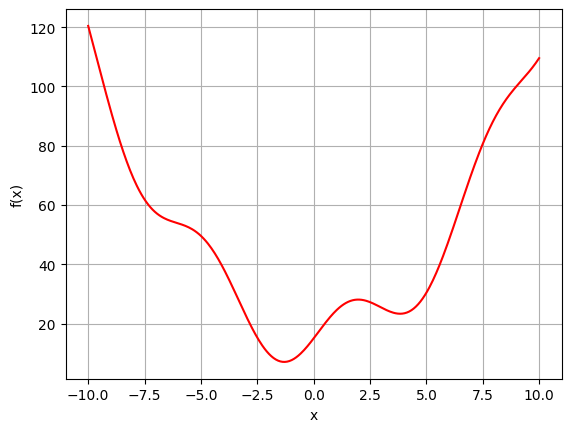

In [6]:
#| echo: false
#| label: fig-f-of-x
#| fig-cap: "$f(x) = x^{2} + 10 * sin(x)+ 15$ (plotted from -10 to 10)"
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x):
    return x**2 + 10 * np.sin(x) + 15

x = np.linspace(-10, 10, 400)
y = f(x)

plt.plot(x, y, 'r')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

## Building a strategy

### Random

In order to solve this problem and to understand how simulated annealing does it, we should look at it from a statistical perspective. Perhaps the simplest approach at finding a solution is to pick a value randomly. How high would the probability of finding the solution that way be? We can visualize this strategy using a probability density function.

In [8]:
def algorithm_a(f, iterations):
  x_values = []
  y_values = []
  for t in range(iterations):
    x_values.append(random.uniform(-20, 20)) # <1>
    y_values.append(f(x_values[t]))

  return x_values, y_values

1. At each timestep we just select a random $x$ for our function

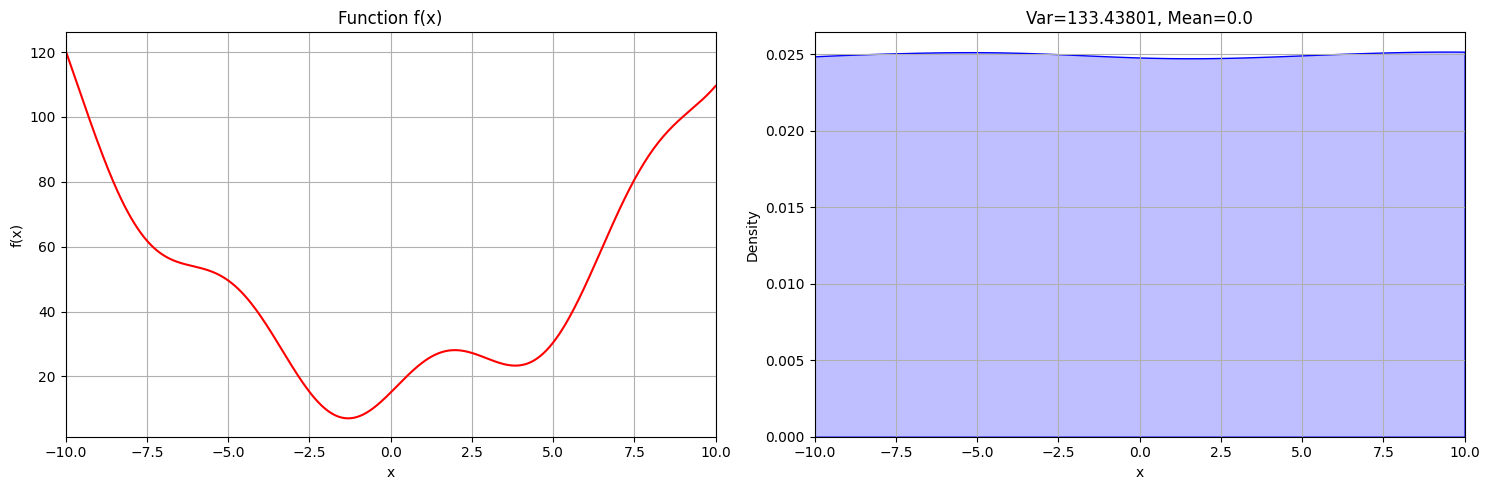

In [25]:
#| echo: false
#| label: fig-pdf-random
#| fig-cap: "Probability density function for the 'random' strategy"
x_values_random, y_values_random = algorithm_a(f, 10000)

# Create a figure with two subplots arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjusted to a 1x2 grid

# Plot the function on the first subplot
x = np.linspace(-10, 10, 400)
y = f(x)
axs[0].plot(x, y, 'r', label='Function f(x)')
axs[0].set_title('Function f(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].set_xlim([-10, 10])
axs[0].grid(True)

# Plot the PDF of the search process on the second subplot
sns.kdeplot(x_values_random, ax=axs[1], clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label='PDF of x values')
axs[1].set_title(f'Var={np.var(x_values_random):.5f}, Mean={np.mean(x_values_random):.1f}')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Density')
axs[1].grid(True)
axs[1].set_xlim([-10, 10])

# Adjust the layout
plt.tight_layout()
plt.show()


As you can see, all values of x are equally likely to be picked as the solution, which is of course wrong. Ideally, we want our algorithm to find the solution more often than the wrong answers.

### Preference

In order to do this, at each timestep we could make define our algorithm in a way, that it's more likely that an improvement will be accepted rather than an regression in cost. The simplest way would be to accept worse solutions only sometimes, say 50% of the time:

In [26]:
def algorithm_b(f, iterations, initial_x):
  x_values = [initial_x]
  y_values = [f(initial_x)]

  for t in range(iterations):
    current_x, current_y = x_values[len(x_values)-1], y_values[len(y_values)-1]
    new_x = random.uniform(-20, 20)
    new_y = f(new_x)
    if new_y < current_y or random.random() < 0.50: # <1>
      x_values.append(new_x)
      y_values.append(new_y)

  return x_values, y_values

1. Only accept "worse" solutions 50% of the time

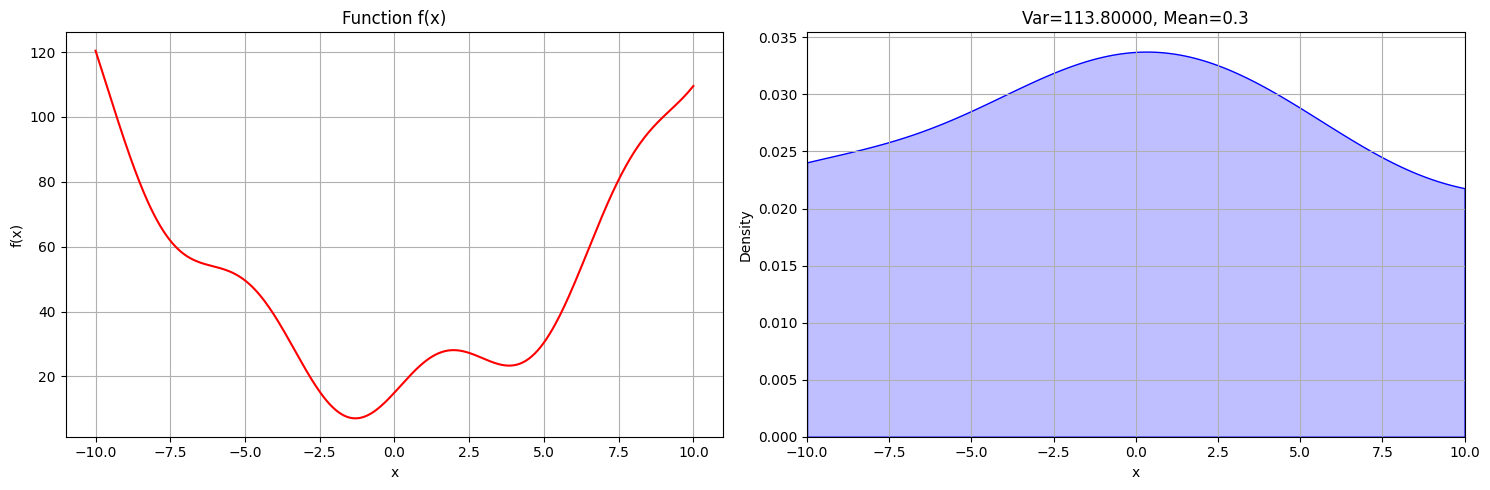

In [22]:
#| echo: false
#| label: fig-pdf-preference
#| fig-cap: "Probability density function for the 'preference' strategy"
x_values_random, y_values_random = algorithm_b(f, 1000, np.random.uniform(-20, 20))

# Create a figure with two subplots
fig, axs = plt.subplots(1,2, figsize=(15, 5))

# Plot the function on the first subplot
x = np.linspace(-10, 10, 400)
y = f(x)
axs[0].plot(x, y, 'r', label='Function f(x)')
axs[0].set_title('Function f(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[1].set_xlim([-10, 10])
axs[0].grid(True)

# Plot the PDF of the search process on the second subplot
sns.kdeplot(x_values_random, ax=axs[1], clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label='PDF of x values')
axs[1].set_title(f'Var={np.var(x_values_random):.5f}, Mean={np.mean(x_values_random):.1f}')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Density')
axs[1].grid(True)
axs[1].set_xlim([-10, 10])

# Adjust the layout
plt.tight_layout()
plt.show()


### Neighbours

But we can do even better than that. The current implementation is kind of inefficient because the progress we made will be reset on every timestep. Imagine trying to solve a rubix cube, but instead of slowly building up your solution, you choose a completely random new configuration every time you make a turn, instead of improving the current one. So instead of choosing an entirley new solution every time we make a move, let's only consider neighbouring solutions, that is solution withing a certain radius of the current one. This is one important concept that simulated annealing employs.

In [27]:
def algorithm_c(f, iterations, initial_x, p):
  x_values = [initial_x]
  y_values = [f(initial_x)]

  for t in range(iterations):
    current_x, current_y = x_values[len(x_values)-1], y_values[len(y_values)-1]
    new_x = x_values[len(x_values)-1] + random.uniform(-1, 1) # <1>
    new_y = f(new_x)
    if new_y < current_y or random.random() < p:
      x_values.append(new_x)
      y_values.append(new_y)

  return x_values, y_values

1. Only consider neighbouring values of the current states by reducing the interval that we sample from to $[-1, 1]$

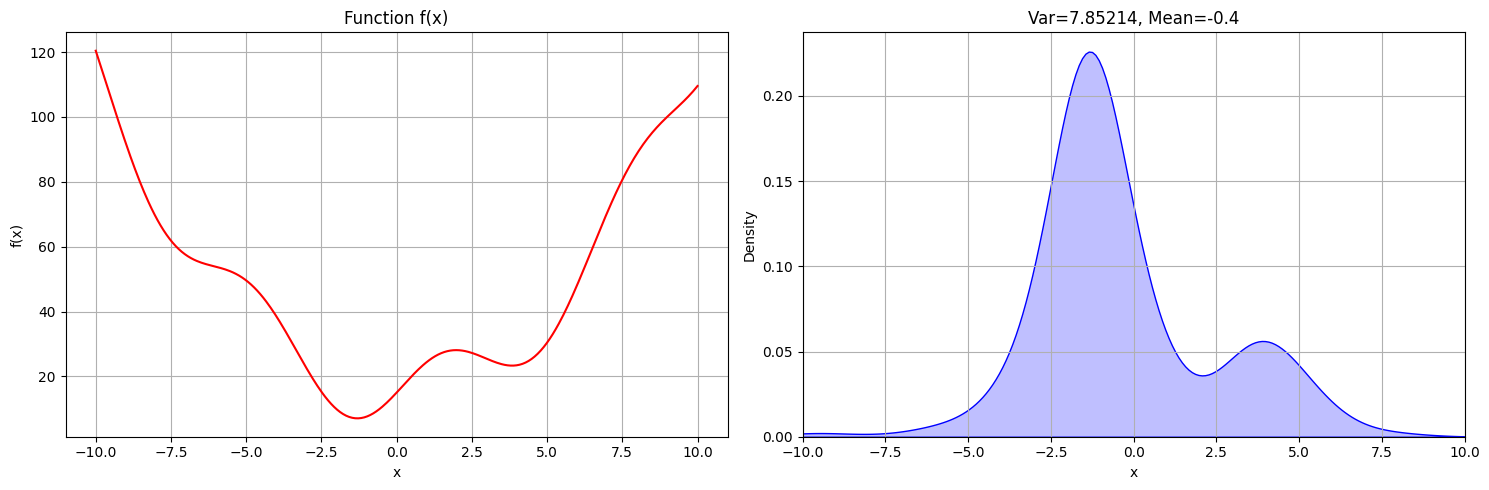

In [24]:
#| echo: false
#| label: fig-pdf-neighbour
#| fig-cap: "Probability density function for the 'neighbour' strategy"
x_values_random, y_values_random = algorithm_c(f, 10000, np.random.uniform(-20, 20), 0.5)

# Create a figure with two subplots
fig, axs = plt.subplots(1,2, figsize=(15,5))

# Plot the function on the first subplot
x = np.linspace(-10, 10, 400)
y = f(x)
axs[0].plot(x, y, 'r', label='Function f(x)')
axs[0].set_title('Function f(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[1].set_xlim([-10, 10])
axs[0].grid(True)

# Plot the PDF of the search process on the second subplot
sns.kdeplot(x_values_random, ax=axs[1], clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label='PDF of x values')
axs[1].set_title(f'Var={np.var(x_values_random):.5f}, Mean={np.mean(x_values_random):.1f}')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Density')
axs[1].grid(True)
axs[1].set_xlim([-10, 10])

# Adjust the layout
plt.tight_layout()
plt.show()

As you can see, the probability that the algorithm yields the correct solution is a lot higher than for any other value. But it's still not guaranteed and a lot of the time it returns wrong answers. The variance is still too high. Ideally, we'd always want the tip of the pdf to be returned as our solution and ignore all the other values. How can we solve this? This is where simulated annealing introduces a final concept and it is what makes it so elegant and special.